# FIVO in (Gaussian) LDS Notebook


In [1]:
import jax
import jax.numpy as np
import matplotlib.pyplot as plt
from jax.scipy import special as spsp
from jax import vmap
from jax import random as jr
from tensorflow_probability.substrates.jax import distributions as tfd
from typing import NamedTuple, Any
from flax import optim
from copy import deepcopy as dc

# Import some ssm stuff.
from ssm.utils import Verbosity, random_rotation
from ssm.inference.smc import smc, plot_single_sweep
from ssm.inference.em import em
import ssm.distributions as ssmd
from ssm.inference.snaxplicit import IndependentGaussianGenerator
import ssm.snax.snax as snax
from ssm.lds.models import GaussianLDS

from ssm.inference.fivo import *

# Set the default verbosity.
default_verbosity = Verbosity.DEBUG

# Set the initial PRNG key.
key = jax.random.PRNGKey(2)

# 1. Create Gaussian LDS and Observed Data.

#### Set up true model.

In [2]:
latent_dim = 3
emissions_dim = 5

# Create a more reasonable emission scale.
transition_scale_tril = 0.1 * np.eye(latent_dim)
emission_scale_tril = 1.0 * np.eye(emissions_dim)

# Create the true model.
key, subkey = jr.split(key)
true_dynamics_weights = random_rotation(subkey, latent_dim, theta=np.pi / 10)
true_model = GaussianLDS(num_latent_dims=latent_dim, num_emission_dims=emissions_dim, seed=subkey,
                         dynamics_scale_tril=transition_scale_tril,
                         dynamics_weights=true_dynamics_weights,
                         emission_scale_tril=emission_scale_tril)

#### From the true model, we can sample synthetic data

In [3]:
num_trials = 10
num_timesteps = 100

key, subkey = jr.split(key)
true_states, dataset = true_model.sample(key=subkey, num_steps=num_timesteps, num_samples=num_trials)

#### Let's view the synthetic data

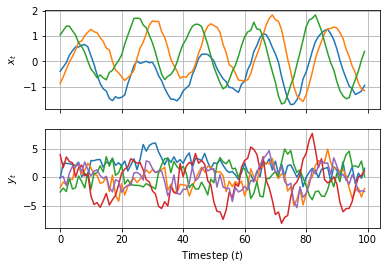

In [4]:
dataset_to_plot = 0
fig, axes = plt.subplots(2, 1, sharex=True, squeeze=True)
axes[0].plot(true_states[dataset_to_plot])
axes[0].grid(True)
axes[0].set_ylabel('$x_t$')
axes[1].plot(dataset[dataset_to_plot])
axes[1].grid(True)
axes[1].set_ylabel('$y_t$')
plt.xlabel('Timestep ($t$)')
plt.pause(0.1)

#### Inference baseline: Use EM to infer the exact posterior over latent state given observes.

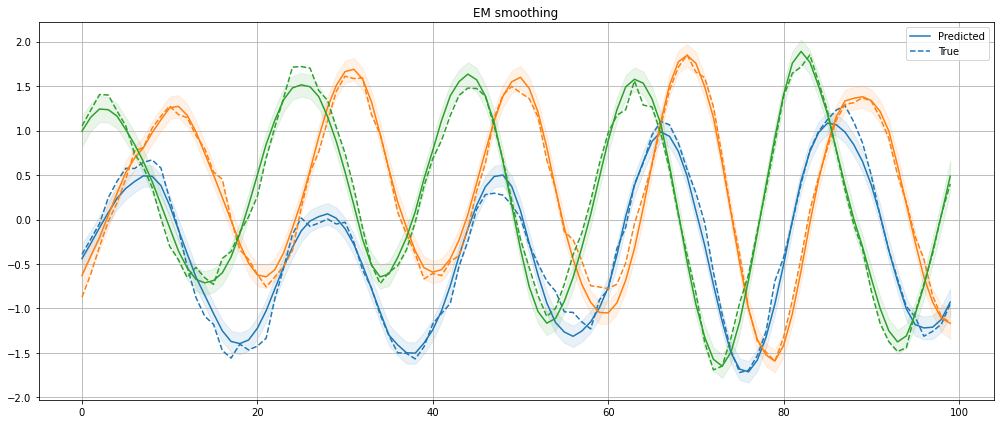

In [6]:
# Test against EM (which for the LDS is exact.
em_posterior = jax.vmap(true_model.infer_posterior)(dataset)
em_log_marginal_likelihood = true_model.marginal_likelihood(dataset, posterior=em_posterior)
em_log_marginal_likelihood = - lexp(em_log_marginal_likelihood)
sweep_em_mean = em_posterior.mean()[0]
sweep_em_sds = np.sqrt(np.asarray([[np.diag(__k) for __k in _k] for _k in em_posterior.covariance()]))[0]
sweep_em_statistics = (sweep_em_mean, sweep_em_mean - sweep_em_sds, sweep_em_mean + sweep_em_sds)
plot_single_sweep(sweep_em_statistics, true_states[0], tag='EM smoothing', preprocessed=True)

p = 0

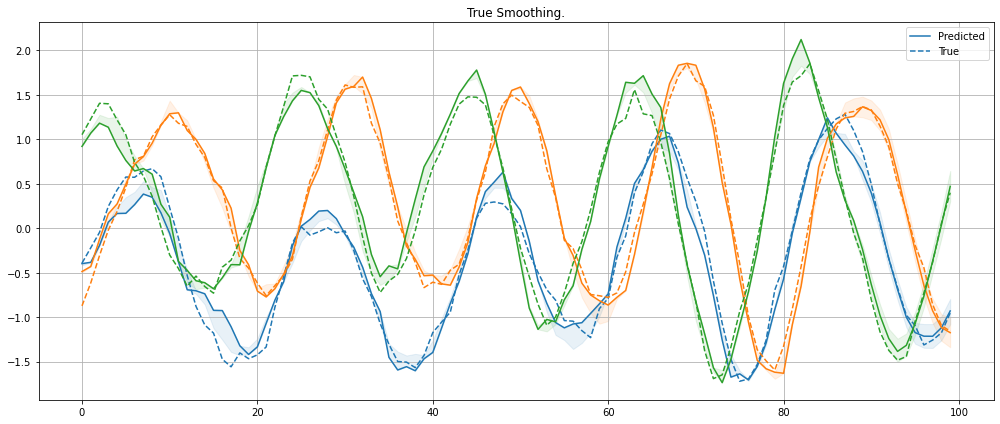

In [7]:
# Test the true model using SMC.
key, subkey = jr.split(key)
true_sweep, true_lml, _, _ = smc(subkey, true_model, dataset, num_particles=5000)
true_lml = - lexp(true_lml)
plot_single_sweep(true_sweep[0], true_states[0], tag='True Smoothing.')
p = 0

# 2. FIVO

In [8]:
# Define a new model which we will optimize.
key, subkey = jax.random.split(key)
model = GaussianLDS(num_latent_dims=latent_dim, num_emission_dims=emissions_dim, seed=subkey,
                    dynamics_scale_tril=transition_scale_tril,
                    emission_weights=true_model.emissions_matrix,
                    emission_scale_tril=emission_scale_tril)

initial_model = dc(model)

# Now define a proposal.
PROPOSAL_STRUCTURE = 'RESQ'  # {'RESQ', 'DIRECT'}.
proposal, proposal_params = None, None  # The default value for these is None.
dummy_proposal_input = (np.ones((latent_dim, )), np.ones((emissions_dim, )))
dummy_proposal_output = (np.ones((latent_dim, )), )
proposal = define_proposal(n_proposals=1,
                           dummy_input=dummy_proposal_input,
                           dummy_output=dummy_proposal_output)
key, subkey = jr.split(key)
proposal_params = proposal.init(subkey)

In [12]:
# This is hella messy.
# TODO - KILL ME NOW.
def accessor_0(_model, _param=None):
    if _param is None:
        return _model._dynamics._distribution.weights
    else:
        _model._dynamics._distribution = ssmd.GaussianLinearRegression(_param,
                                                                       _model._dynamics._distribution.bias,
                                                                       _model._dynamics._distribution.scale_tril)
        return _model

p_params_accessors = (accessor_0, )
p_params = tuple(_a(model) for _a in p_params_accessors)
# TODO - END KILL ME NOW.

In [13]:
# Build up the optimizer.
opt = define_optimizer(p_params, proposal_params)

In [16]:
# Close over constant parameters.
do_fivo_sweep_closed = lambda _k, _p, _num_particles: \
    do_fivo_sweep(_k, model, proposal, _p, p_params_accessors, dataset, _num_particles, PROPOSAL_STRUCTURE)

# Jit this badboy.
do_fivo_sweep_jitted = jax.jit(do_fivo_sweep_closed, static_argnums=2)

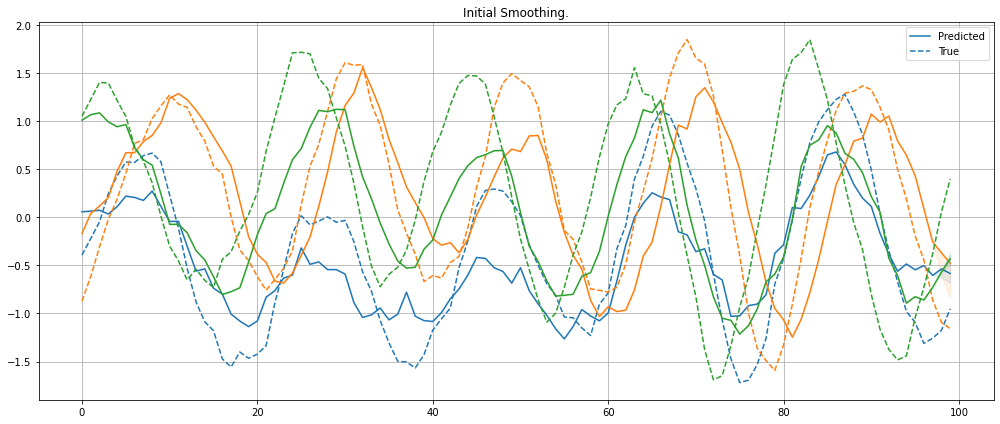

Step:     0,  True Neg-LML:  758.326,  Pred Neg-LML: 1043.378  EM Neg-LML:  758.269
True: dynamics:     0.97442   -0.16485    0.15274    0.12792    0.96565    0.22616   -0.18478   -0.20084    0.96204
Pred: dynamics:     0.99634   -0.06870   -0.05082    0.07478    0.98876    0.12949    0.04136   -0.13282    0.99028
True: log-var:     -4.60517   -4.60517   -4.60517
Pred: q log-var:   -0.12488    0.09851   -0.13589



In [17]:
# Test SMC in the initial model.
key, subkey = jr.split(key)
initial_lml, initial_sweep = do_fivo_sweep_jitted(subkey, get_params(opt), _num_particles=5000)
sweep_fig = plot_single_sweep(initial_sweep[0], true_states[0], tag='Initial Smoothing.')
do_print(0, initial_lml, true_model, true_lml, opt, em_log_marginal_likelihood)

#### Learn model (and proposal) with FIVO.

In [ ]:
opt_steps = 100000

for _step in range(opt_steps):

    key, subkey = jr.split(key)
    do_fivo_sweep_val_and_grad = jax.value_and_grad(do_fivo_sweep_jitted, argnums=1, has_aux=True)
    (lml, smooth), grad = do_fivo_sweep_val_and_grad(subkey, get_params(opt), num_particles)
    opt = apply_gradient(grad, opt, )

    if _step % 1000 == 0:
        key, subkey = jr.split(key)
        pred_lml, pred_sweep = do_fivo_sweep_jitted(subkey, get_params(opt), _num_particles=5000)
        sweep_fig = plot_single_sweep(pred_sweep[0], true_states[0], tag='{} Smoothing.'.format(_step),
                                      fig=sweep_fig)
        do_print(_step, pred_lml, true_model, true_lml, opt, em_log_marginal_likelihood)
    p = 0

---

---